In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)

import os
os.chdir('/home/aremirata/thesis/7mw/')

from savvyworkout import lstm_preprocess
from savvyworkout import triaxial_lstm
from savvyworkout import triaxial_deepconvlstm
from savvyworkout import deeplearning_utils
#from savvyworkout import visualize_lstmmodel
from sklearn.externals import joblib

#from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.display import display, HTML

%matplotlib inline

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
#from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from scipy import misc
from skimage import color
from sklearn.externals import joblib
import xgboost as xgb
import glob
import seaborn as sns
import pandas as pd
import os
sns.set(style="white", palette="muted", color_codes=True)

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression

In [4]:
from sklearn.metrics import auc, roc_curve, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.pipeline import make_pipeline
from scipy import interp

In [5]:
os.chdir('/home/aremirata/thesis/LSTM-Human-Activity-Recognition')

# Dataset Information

The experiments have been carried out with a group of 30 volunteers within an age bracket of 19-48 years. Each person performed six activities (WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, LAYING) wearing a smartphone (Samsung Galaxy S II) on the waist. Using its embedded accelerometer and gyroscope,3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz were captured. The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used.

### Generating Data

In [6]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

/home/aremirata/thesis/LSTM-Human-Activity-Recognition
data
LICENSE
LSTM_files
LSTM.ipynb
lstm.py
README.md
UCI Activity Recognition_Compressed_ Factorization_Classification.ipynb
UCI Activity Recognition Factorization.ipynb
UCI Activity Recognition_Uncompressed_ Factorization_Classification.ipynb
/home/aremirata/thesis/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/home/aremirata/thesis/LSTM-Human-Activity-Recognition/data
download_dataset.py  __MACOSX  source.txt  UCI HAR Dataset  UCI HAR Dataset.zip
/home/aremirata/thesis/LSTM-Human-Activity-Recognition
data
LICENSE
LSTM_files
LSTM.ipynb
lstm.py
README.md
UCI Activity Recognition_Compressed_ Factorization_Classification.ipynb
UCI Activity Recognition Factorization.ipynb
UCI Activity Recognition_Uncompressed_ Factorization_Classific

In [7]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

In [8]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [9]:
training_data = np.linalg.norm(X_train, axis=-1)
testing_data = np.linalg.norm(X_test, axis=-1)

# Factorization On Training Data

In [ ]:
from nmf_compressed.structured_nmf import structured_randomized_bppnmf
from numpy.linalg import norm, solve
from ntf_cython.nmf import nmf

In [10]:
r = 10

In [14]:
%time W_uncompressed_train, H_uncompressed_train, n_iters_uncompressed, relerror_uncompressed_train = nmf(training_data, n_components=r, max_iter=200, random_state=2)

CPU times: user 59.5 s, sys: 984 ms, total: 1min
Wall time: 5.06 s


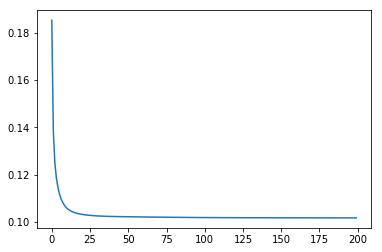

In [15]:
plt.plot(relerror_uncompressed)

In [16]:
joblib.dump(W_uncompressed_train,'/home/aremirata/thesis/models/W_uncompressed_train_UCI.jl')
joblib.dump(H_uncompressed_train,'/home/aremirata/thesis/models/H_uncompressed_train_UCI.jl')
joblib.dump(relerror_uncompressed_train,'/home/aremirata/thesis/models/relerror_uncompressed_train_UCI.jl')

['/home/aremirata/thesis/models/relerror_uncompressed_train_UCI.jl']

In [11]:
U_train = joblib.load('/home/aremirata/thesis/models/W_uncompressed_train_UCI.jl')
V_train = joblib.load('/home/aremirata/thesis/models/H_uncompressed_train_UCI.jl')
relative_error_train = joblib.load('/home/aremirata/thesis/models/relerror_uncompressed_train_UCI.jl')

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file '/home/aremirata/thesis/models/W_uncompressed_train_UCI.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file '/home/aremirata/thesis/models/H_uncompressed_train_UCI.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app


# Factorization On Test Set

In [18]:
%time W_uncompressed_test, H_uncompressed_test, n_iters_uncompressed_test, relerror_uncompressed_test = nmf(testing_data, n_components=r, max_iter=200, random_state=2)

CPU times: user 29.1 s, sys: 628 ms, total: 29.8 s
Wall time: 2.5 s


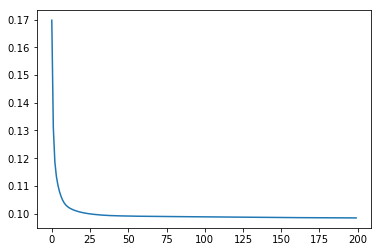

In [19]:
plt.plot(relerror_uncompressed_test)

In [20]:
joblib.dump(W_uncompressed_test,'/home/aremirata/thesis/models/W_uncompressed_test_UCI.jl')
joblib.dump(H_uncompressed_test,'/home/aremirata/thesis/models/H_uncompressed_test_UCI.jl')
joblib.dump(relerror_uncompressed_test,'/home/aremirata/thesis/models/relerror_uncompressed_test_UCI.jl')

['/home/aremirata/thesis/models/relerror_uncompressed_test_UCI.jl']

In [12]:
U_test = joblib.load('/home/aremirata/thesis/models/W_uncompressed_test_UCI.jl')
V_test = joblib.load('/home/aremirata/thesis/models/H_uncompressed_test_UCI.jl')
relative_error_test = joblib.load('/home/aremirata/thesis/models/relerror_uncompressed_test_UCI.jl')

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file '/home/aremirata/thesis/models/W_uncompressed_test_UCI.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':
/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: The file '/home/aremirata/thesis/models/H_uncompressed_test_UCI.jl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  from ipykernel import kernelapp as app


In [13]:
X_train = U_train
X_test = U_test

In [14]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [15]:
print('Original dataset shape {}'.format(Counter(y_train)))
print('Original dataset shape {}'.format(Counter(y_test)))

Original dataset shape Counter({5: 1407, 4: 1374, 3: 1286, 0: 1226, 1: 1073, 2: 986})
Original dataset shape Counter({5: 537, 4: 532, 0: 496, 3: 491, 1: 471, 2: 420})


In [16]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc

In [17]:
def build_models(X, y, classifier=None, samplers=None):
    
    """
    Train model using the given training set and validate it through the validation set.
    If plot is true, the function plots the roc curve.
    
    Parameters
    ----------
    X: 2D-array
        Contains features from the dimension reduction methods used
        for training the dataset
    y: 
        The target variable we want to predict
    """
    
    best_model = None
    best_roc = -1
    
    cv = StratifiedKFold(n_splits=3)
    
    

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    for train, test in cv.split(X, y):

        dtrain = xgb.DMatrix(X[train], label=y[train])
        dtest = xgb.DMatrix(X[test], label=y[test])

        n_classes = len(np.unique(y))

        param = {
            'max_depth': 3,  # the maximum depth of each tree
            'eta': 0.3,  # the training step for each iteration
            'silent': 1,  # logging mode - quiet
            'objective': 'multi:softprob',  # error evaluation for multiclass training
            'num_class': n_classes}  # the number of classes that exist in this datset

        num_round = 20  # the number of training iterations

        bst = xgb.train(param, dtrain, num_round)
        y_score = bst.predict(dtest)

        y_train = label_binarize(y[train], classes=list(np.unique(y)))
        y_test = label_binarize(y[test], classes=list(np.unique(y)))

        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

        # Then interpolate all ROC curves at this points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += interp(all_fpr, fpr[i], tpr[i])

        # Finally average it and compute AUC
        mean_tpr /= n_classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


        if roc_auc["macro"] > best_roc:
            best_roc = roc_auc["macro"]
            best_model = bst
                

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(all_fpr, mean_tpr)
    plt.plot(all_fpr, mean_tpr, linestyle='--',
             label='XGB Multilabel Classifier: (AUROC : %.3f))'% ( mean_auc), lw=2)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
             label='Luck')

    # make nice plotting
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')

    plt.legend(loc="lower right")

    plt.show()
    
    return best_model

/home/aremirata/.conda/envs/claims/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


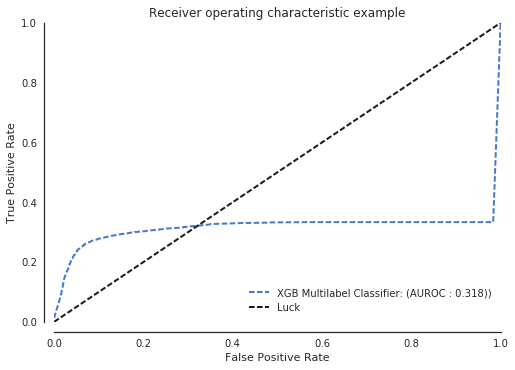

In [18]:
RANDOM_STATE = 42
xgb_model = build_models(X_train, y_train)

In [19]:
xgboost = xgb_model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

y_score = xgboost.predict(dtest)

n_classes = len(np.unique(y_train))

y_train = label_binarize(y_train, classes=list(np.unique(y_train)))
y_test = label_binarize(y_test, classes=list(np.unique(y_test)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
print("The roc auc score using {} classifier is {}".format('xgboost',roc_auc["macro"]))

The roc auc score using xgboost classifier is 0.7277494019162352
